In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
!pip install efficientnet_pytorch


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=cd546163e79ce844f7255a6b8e97173ce54910c246fca5cde3d17a4354ddff42
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import torch.nn as nn
import copy,time
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets
import os, glob
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch.optim as optim
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
batch_size = 8
epochs = 150
data_dir = "/content/drive/My Drive/personal_color/Data/"


In [8]:
trainset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/personal_color/Data/train/",
                                           transform=transforms.ToTensor())
testset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/personal_color/Data/test/",
                                          transform=transforms.ToTensor())
valtset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/personal_color/Data/val/",
                                          transform=transforms.ToTensor())



In [9]:
data_transforms = {'train': transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Resize((224,224))
    ]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Resize((224,224))])
    
    }

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'test','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','val']}

In [11]:
image_datasets['train'].classes

['fall_deep_train',
 'fall_mute_train',
 'fall_strong_train',
 'spring_bright_train',
 'spring_light_train',
 'summer_bright_train',
 'summer_light_train',
 'summer_mute_train',
 'winter_bright_train',
 'winter_deep_train']

In [12]:
class_names={
'0':'fall_deep_test',
'1':'fall_mute_test',
 '2':'fall_strong_test',
 '3':'spring_bright_test',
'4':'spring_light_test',
'5': 'summer_bright_test',
 '6':'summer_light_test',
 '7':'summer_mute_test',
 '8':'winter_bright_test',
 '9':'winter_deep_test'
}

In [5]:
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)
summary(model, input_size=(3,224,224), device='cpu')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)           
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/My Drive/personal_color/effi2.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [15]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )
        self.se = SEBlock(in_channels * MBConv.expand, se_scale)
        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x
        
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

In [22]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef
        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)
def efficientnet_b0(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(3, 3, 224, 224).to(device)
eff = efficientnet_b0().to(device)
output = eff(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(eff.parameters(), 
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.95 ** epoch)

In [17]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(eff, criterion, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.32 Acc: 10.0
val Loss: 2.31 Acc: 12.9
==> best model saved - 0 / 12.9
Epoch 1/29
----------
train Loss: 2.32 Acc: 9.8
val Loss: 2.39 Acc: 11.2
Epoch 2/29
----------
train Loss: 2.32 Acc: 9.9
val Loss: 2.31 Acc: 11.0
Epoch 3/29
----------
train Loss: 2.32 Acc: 9.6
val Loss: 2.31 Acc: 8.8
Epoch 4/29
----------
train Loss: 2.32 Acc: 9.7
val Loss: 2.34 Acc: 10.5
Epoch 5/29
----------
train Loss: 2.32 Acc: 9.8
val Loss: 2.32 Acc: 7.6
Epoch 6/29
----------
train Loss: 2.32 Acc: 9.7
val Loss: 2.35 Acc: 11.0
Epoch 7/29
----------
train Loss: 2.32 Acc: 9.7
val Loss: 2.37 Acc: 12.7
Epoch 8/29
----------
train Loss: 2.32 Acc: 9.3
val Loss: 2.47 Acc: 10.5
Epoch 9/29
----------
train Loss: 2.32 Acc: 9.1
val Loss: 2.32 Acc: 8.5
Epoch 10/29
----------
train Loss: 2.32 Acc: 9.6
val Loss: 2.30 Acc: 9.8
Epoch 11/29
----------
train Loss: 2.32 Acc: 9.5
val Loss: 2.37 Acc: 10.0
Epoch 12/29
----------
train Loss: 2.32 Acc: 10.0
val Loss: 2.38 Acc: 7.8
Epoch 13/29
-------

best model : 0 - 13 / 2.3


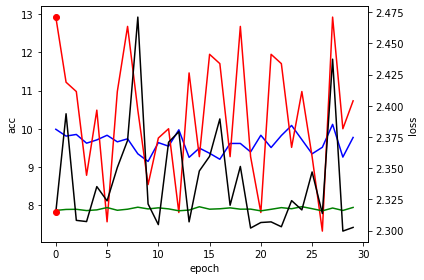

In [18]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()
ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
fig.tight_layout()
plt.show()

In [19]:
def test_model(model, phase = 'val'):    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    running_loss, running_corrects, num_cnt = 0.0, 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) 
            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0) 
        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))
    model.train(mode=was_training);  

In [21]:
test_model(model, phase = 'val')

test done : loss/acc : 2.31 / 12.9


<Figure size 432x288 with 0 Axes>

In [ ]:
######################

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.95 ** epoch)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=151)

Epoch 0/150
----------
train Loss: 1.63 Acc: 44.0
val Loss: 3.20 Acc: 21.5
==> best model saved - 0 / 21.5
Epoch 1/150
----------
train Loss: 0.90 Acc: 70.6
val Loss: 3.56 Acc: 22.4
==> best model saved - 1 / 22.4
Epoch 2/150
----------
train Loss: 0.64 Acc: 79.0
val Loss: 4.48 Acc: 22.7
==> best model saved - 2 / 22.7
Epoch 3/150
----------
train Loss: 0.49 Acc: 84.3
val Loss: 3.82 Acc: 22.9
==> best model saved - 3 / 22.9
Epoch 4/150
----------
train Loss: 0.42 Acc: 86.6
val Loss: 4.11 Acc: 26.3
==> best model saved - 4 / 26.3
Epoch 5/150
----------
train Loss: 0.35 Acc: 88.6
val Loss: 4.48 Acc: 24.1
Epoch 6/150
----------
train Loss: 0.30 Acc: 90.4
val Loss: 4.75 Acc: 23.9
Epoch 7/150
----------
train Loss: 0.27 Acc: 91.3
val Loss: 4.86 Acc: 24.1
Epoch 8/150
----------
train Loss: 0.23 Acc: 92.5
val Loss: 4.84 Acc: 23.7
Epoch 9/150
----------
train Loss: 0.21 Acc: 93.4
val Loss: 5.04 Acc: 24.9
Epoch 10/150
----------
train Loss: 0.20 Acc: 93.8
val Loss: 4.91 Acc: 26.8
==> best model

best model : 105 - 30 / 5.6


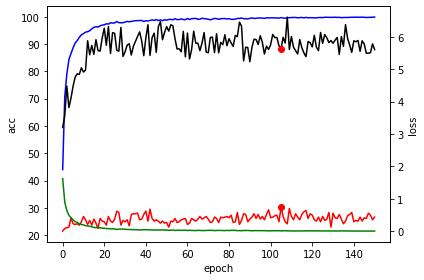

In [ ]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()
ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
def test_model(model, phase = 'val'):    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    running_loss, running_corrects, num_cnt = 0.0, 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) 
            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0) 
        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))
    model.train(mode=was_training);  

In [ ]:
test_model(model, phase = 'test')

test done : loss/acc : 5.63 / 30.2


<Figure size 432x288 with 0 Axes>

In [ ]:
#################################################################################################################################

In [ ]:
VGG16= [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M']

In [ ]:
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_laters(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.fcs(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: 
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vgg = VGGnet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)
print(vgg)

cuda
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), 
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-1)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.95 ** epoch)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)           
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/My Drive/personal_color/vgg2.pth')
    print('model saved')
    print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
    fig, ax1 = plt.subplots()

    ax1.plot(train_acc, 'b-')
    ax1.plot(valid_acc, 'r-')
    plt.plot(best_idx, valid_acc[best_idx], 'ro')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('acc', color='k')
    ax1.tick_params('y', colors='k')

    ax2 = ax1.twinx()
    ax2.plot(train_loss, 'g-')
    ax2.plot(valid_loss, 'k-')
    plt.plot(best_idx, valid_loss[best_idx], 'ro')
    ax2.set_ylabel('loss', color='k')
    ax2.tick_params('y', colors='k')
    fig.tight_layout()
    plt.show()
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)           
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/My Drive/personal_color/vgg2.pth')
    print('model saved')
    print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
    fig, ax1 = plt.subplots()

    ax1.plot(train_acc, 'b-')
    ax1.plot(valid_acc, 'r-')
    plt.plot(best_idx, valid_acc[best_idx], 'ro')
    ax1.set_xlabel('epoch')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('acc', color='k')
    ax1.tick_params('y', colors='k')

    ax2 = ax1.twinx()
    ax2.plot(train_loss, 'g-')
    ax2.plot(valid_loss, 'k-')
    plt.plot(best_idx, valid_loss[best_idx], 'ro')
    ax2.set_ylabel('loss', color='k')
    ax2.tick_params('y', colors='k')
    fig.tight_layout()
    plt.show()
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

Epoch 0/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
==> best model saved - 0 / 5.6
Epoch 1/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 2/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 3/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 4/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 5/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 6/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 7/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 8/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 9/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 10/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 11/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 12/29
----------
train Loss: nan Acc: 12.7
val Loss: nan Acc: 5.6
Epoch 13/29
----------
train Loss: nan Acc:

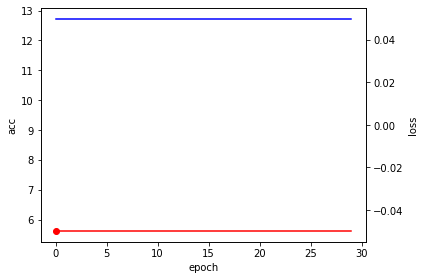

(VGGnet(
   (conv_layers): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
     (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): ReLU()
     (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU()
     (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (14): Conv2d(128, 256, ker

In [ ]:
train_model(vgg, criterion, optimizer, scheduler, num_epochs=30)

best model : 0 - 6 / 0.1


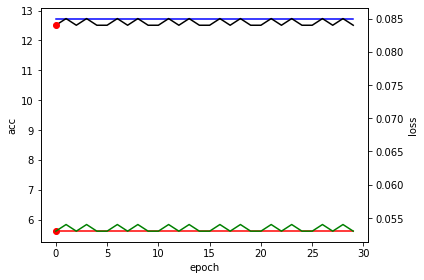

In [ ]:
print('best model : %d - %1.f / %.1f'%(0, valid_acc[0], valid_loss[0]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(0, valid_acc[0], 'ro')
ax1.set_xlabel('epoch')
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(0, valid_loss[0], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()